### 00 - Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import cv2 
from skimage.io import imshow, imread, imsave
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import random
import scipy
from sklearn.model_selection import train_test_split

### 01 - Load the images

In [2]:
# Step 0: Load and preprocess the data
rgb_images_dir = "C:/Github/aerial-semantic-segmentation/dataset_here/dataset/semantic_drone_dataset/original_images"
bw_images_dir = "C:/Github/aerial-semantic-segmentation/dataset_here/dataset/semantic_drone_dataset/label_images_semantic"
color_masks_dir = "C:/Github/aerial-semantic-segmentation/dataset_here/RGB_color_image_masks/RGB_color_image_masks"
csv_file = "C:/Github/aerial-semantic-segmentation/dataset_here/class_dict_seg.csv"
print("Loading the dataset...")
print(rgb_images_dir)
print(bw_images_dir)
print(color_masks_dir)
print(csv_file)

Loading the dataset...
C:/Github/aerial-semantic-segmentation/dataset_here/dataset/semantic_drone_dataset/original_images
C:/Github/aerial-semantic-segmentation/dataset_here/dataset/semantic_drone_dataset/label_images_semantic
C:/Github/aerial-semantic-segmentation/dataset_here/RGB_color_image_masks/RGB_color_image_masks
C:/Github/aerial-semantic-segmentation/dataset_here/class_dict_seg.csv


#### Pre processing of data

In [3]:
def load_data():
    rgb_images = []
    rgb_images_names = []
    bw_images = []
    bw_images_names = []
    color_masks = []
    color_masks_names = []

    # Load RGB images
    for image_name in sorted(os.listdir(rgb_images_dir)):
        image_path = os.path.join(rgb_images_dir, image_name)
        if image_name.lower().endswith('.jpg') or image_name.lower().endswith('.jpeg'):
            label = os.path.splitext(image_name)[0]
            rgb_images.append(image_path)
            rgb_images_names.append(label)

    # Load black and white images
    for image_name in sorted(os.listdir(bw_images_dir)):
        image_path = os.path.join(bw_images_dir, image_name)
        if image_name.lower().endswith('.png'):
            label = os.path.splitext(image_name)[0]
            bw_images.append(image_path)
            bw_images_names.append(label)

    # Load color masks
    for image_name in sorted(os.listdir(color_masks_dir)):
        image_path = os.path.join(color_masks_dir, image_name)
        if image_name.lower().endswith('.png'):
            label = os.path.splitext(image_name)[0]
            color_masks.append(image_path)
            color_masks_names.append(label)

    return rgb_images, bw_images, color_masks

# Call the function to load the data
rgb_images, bw_images, color_masks = load_data()

# Print the number of images loaded
print("Number of RGB images loaded:", len(rgb_images))
print("Number of black and white images loaded:", len(bw_images))
print("Number of color masks loaded:", len(color_masks))

Number of RGB images loaded: 400
Number of black and white images loaded: 400
Number of color masks loaded: 400


#### Visualize the data

RGB image has shape: (4000, 6000, 3)
RGB image has size: 72000000
Black and white image has shape: (4000, 6000, 3)
Black and white image has size: 72000000
Color mask has shape: (4000, 6000, 3)
Color mask has size: 72000000


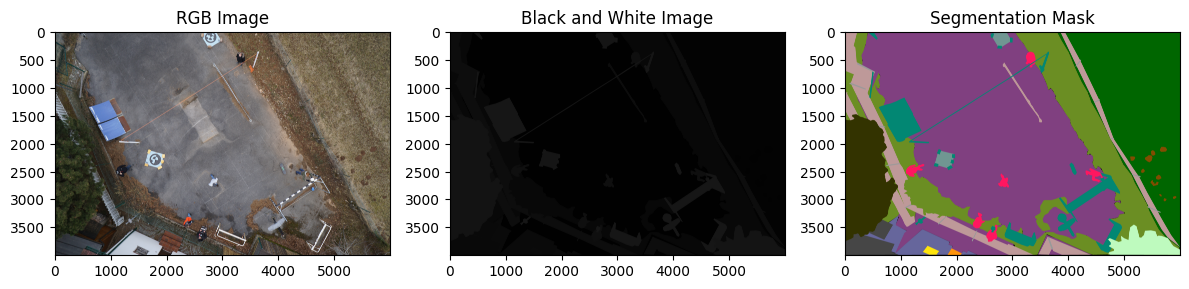

In [4]:
import matplotlib.pyplot as plt

# Select an image index to visualize
selected_index = 1

# Load the selected images
rgb_image = cv2.imread(rgb_images[selected_index])
bw_image = cv2.imread(bw_images[selected_index])
color_mask = cv2.imread(color_masks[selected_index])

# Display information about that rgb images such as size and shape
print("RGB image has shape:", rgb_image.shape)
print("RGB image has size:", rgb_image.size)

# Display information about that black and white images such as size and shape
print("Black and white image has shape:", bw_image.shape)
print("Black and white image has size:", bw_image.size)

# Display information about that color mask such as size and shape
print("Color mask has shape:", color_mask.shape)
print("Color mask has size:", color_mask.size)


# Create a figure with subplots to display the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot RGB image
axes[0].imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
axes[0].set_title("RGB Image")

# Plot black and white image
axes[1].imshow(cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB))
axes[1].set_title("Black and White Image")

# Plot color mask
axes[2].imshow(cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB))
axes[2].set_title("Segmentation Mask")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Do some pre processing on the images

Number of resized RGB images: 400
Number of resized black and white images: 400
Number of resized color masks: 400


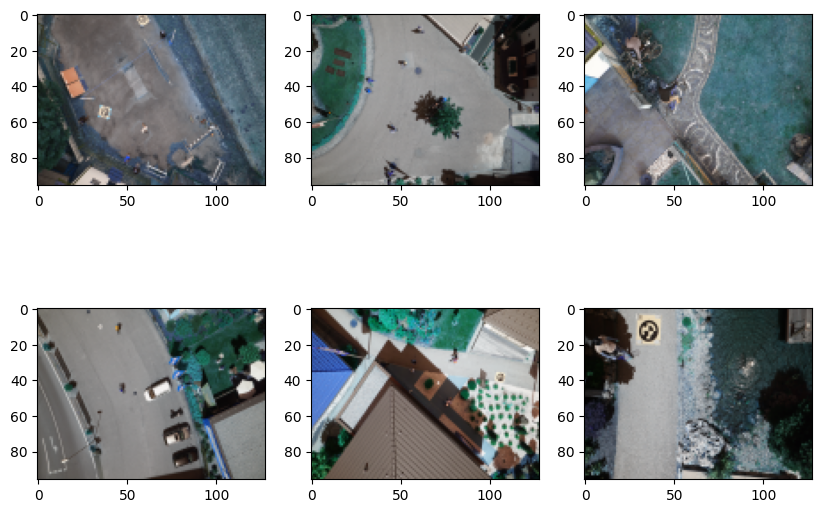

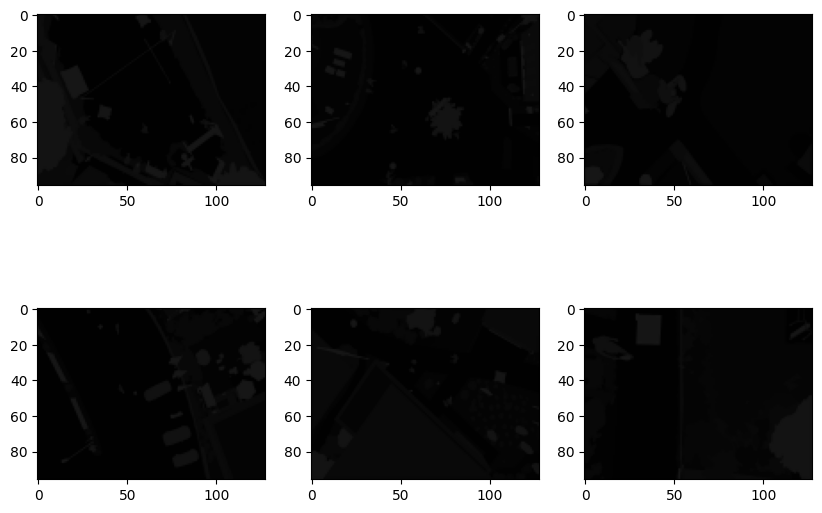

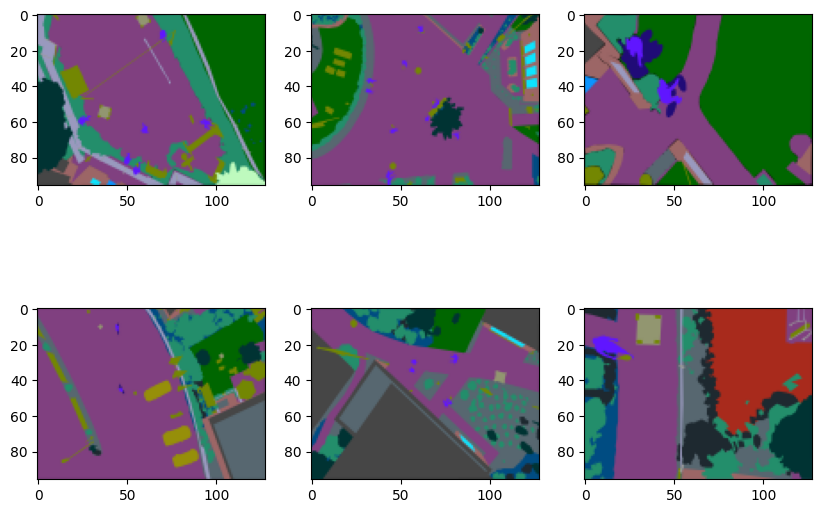

In [5]:
# Resize all the images sets to be size 256x256
def resize_images(rgb_images, bw_images, color_masks):
    resized_rgb_images = []
    resized_bw_images = []
    resized_color_masks = []

    for i in range(len(rgb_images)):
        rgb_image = cv2.imread(rgb_images[i])
        bw_image = cv2.imread(bw_images[i])
        color_mask = cv2.imread(color_masks[i])

        # Resize RGB images
        resized_rgb_image = cv2.resize(rgb_image, (128, 96), interpolation=cv2.INTER_AREA)
        resized_rgb_images.append(resized_rgb_image)

        # Resize black and white images
        resized_bw_image = cv2.resize(bw_image, (128, 96), interpolation=cv2.INTER_AREA)
        resized_bw_images.append(resized_bw_image)

        # Resize color masks
        resized_color_mask = cv2.resize(color_mask, (128, 96), interpolation=cv2.INTER_AREA)
        resized_color_masks.append(resized_color_mask)

    return resized_rgb_images, resized_bw_images, resized_color_masks

# Call the function to resize the images
resized_rgb_images, resized_bw_images, resized_color_masks = resize_images(rgb_images, bw_images, color_masks)

# Print the number of images resized
print("Number of resized RGB images:", len(resized_rgb_images))
print("Number of resized black and white images:", len(resized_bw_images))
print("Number of resized color masks:", len(resized_color_masks))

# Visualise some of the images from the dataset
fig = plt.figure(figsize=(10, 7))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = resized_rgb_images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Visualise some of the images from the dataset
fig = plt.figure(figsize=(10, 7))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = resized_bw_images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Visualise some of the images from the dataset
fig = plt.figure(figsize=(10, 7))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = resized_color_masks[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# # Convert the images to numpy arrays
# resized_rgb_images = np.array(resized_rgb_images)
# resized_bw_images = np.array(resized_bw_images)
# resized_color_masks = np.array(resized_color_masks)

# # Print the shape of the resized images
# print("Shape of resized RGB images:", resized_rgb_images.shape)
# print("Shape of resized black and white images:", resized_bw_images.shape)
# print("Shape of resized color masks:", resized_color_masks.shape)



In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### Split the data into train and test sets

In [7]:
# Step 2: Prepare the training data
# the new data is resized_rgb_images, resized_bw_images, resized_color_masks
input_images = resized_rgb_images  # Use RGB images as input
output_masks = resized_color_masks  # Use color masks as output

# input_images = rgb_images  # Use RGB images as input
# output_masks = color_masks  # Use color masks as output

# Step 3: Split the data
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Split into train and test sets
train_images, test_images, train_masks, test_masks = train_test_split(input_images, output_masks, test_size=test_ratio, random_state=42)

# Further split train set into train and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)


# Convert this list to numpy array
train_images = np.array(train_images)
train_masks = np.array(train_masks)
val_images = np.array(val_images)
val_masks = np.array(val_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [8]:
# Print the number of images and masks
print("Number of train images:", len(train_images))
print("Number of train masks:", len(train_masks))
print("Number of val images:", len(val_images))
print("Number of val masks:", len(val_masks))
print("Number of test images:", len(test_images))
print("Number of test masks:", len(test_masks))

# Print the type of the train, val and test sets
print("Type of train images:", type(train_images))
print("Type of train masks:", type(train_masks))
print("Type of val images:", type(val_images))
print("Type of val masks:", type(val_masks))
print("Type of test images:", type(test_images))
print("Type of test masks:", type(test_masks))

# Print the shape of the train, val and test sets
print("Shape of train images:", train_images.shape)
print("Shape of train masks:", train_masks.shape)
print("Shape of val images:", val_images.shape)
print("Shape of val masks:", val_masks.shape)
print("Shape of test images:", test_images.shape)
print("Shape of test masks:", test_masks.shape)

Number of train images: 279
Number of train masks: 279
Number of val images: 81
Number of val masks: 81
Number of test images: 40
Number of test masks: 40
Type of train images: <class 'numpy.ndarray'>
Type of train masks: <class 'numpy.ndarray'>
Type of val images: <class 'numpy.ndarray'>
Type of val masks: <class 'numpy.ndarray'>
Type of test images: <class 'numpy.ndarray'>
Type of test masks: <class 'numpy.ndarray'>
Shape of train images: (279, 96, 128, 3)
Shape of train masks: (279, 96, 128, 3)
Shape of val images: (81, 96, 128, 3)
Shape of val masks: (81, 96, 128, 3)
Shape of test images: (40, 96, 128, 3)
Shape of test masks: (40, 96, 128, 3)


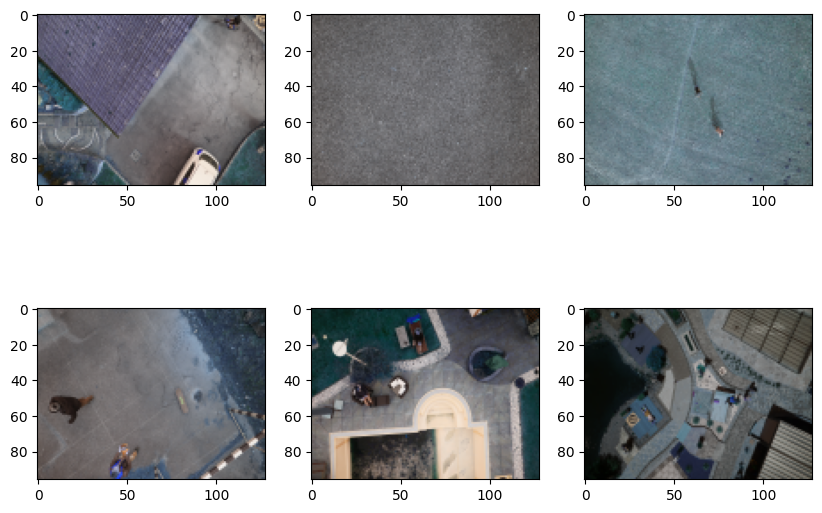

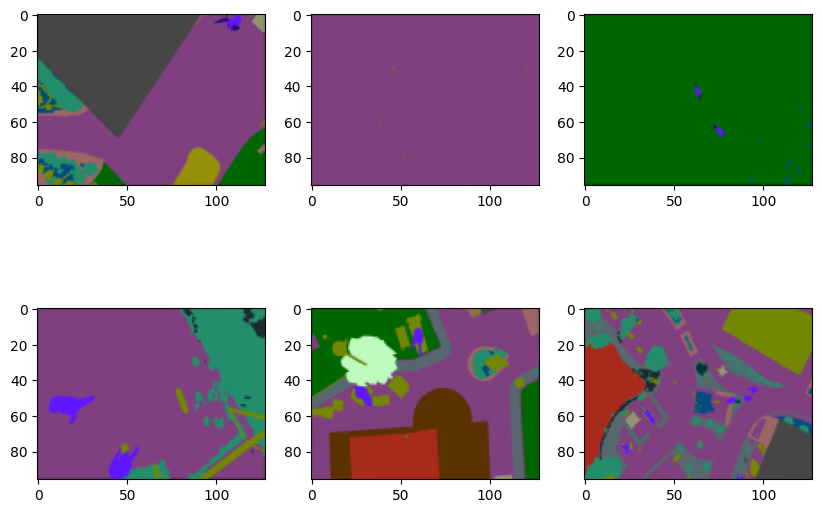

<Figure size 1000x700 with 0 Axes>

In [9]:
# Visualise some of the images from each of train images, val images and test images and their corresponding masks
fig = plt.figure(figsize=(10, 7))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = train_images[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

fig = plt.figure(figsize=(10, 7))
columns = 3
rows = 2

for i in range(1, columns*rows +1):
    img = train_masks[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

fig = plt.figure(figsize=(10, 7))
columns = 3
rows = 2


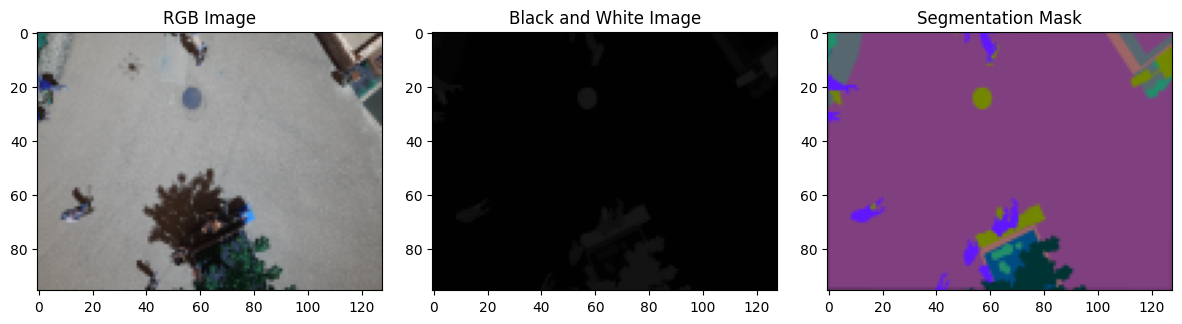

In [10]:
# Create a figure with subplots to display the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot RGB image
axes[0].imshow(resized_rgb_images[0])
axes[0].set_title("RGB Image")

# Plot black and white image
axes[1].imshow(resized_bw_images[0])
axes[1].set_title("Black and White Image")
 
# Plot color mask
axes[2].imshow(resized_color_masks[0])
axes[2].set_title("Segmentation Mask")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

DCNN Model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# imports
import time
from time import process_time
import numpy as np
import numpy
import scipy.io
import cv2
from tensorboard import notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from skimage.color import convert_colorspace
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

Deep Lab v3

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 64, 32)   0           ['bn_Conv1[0][0]']           

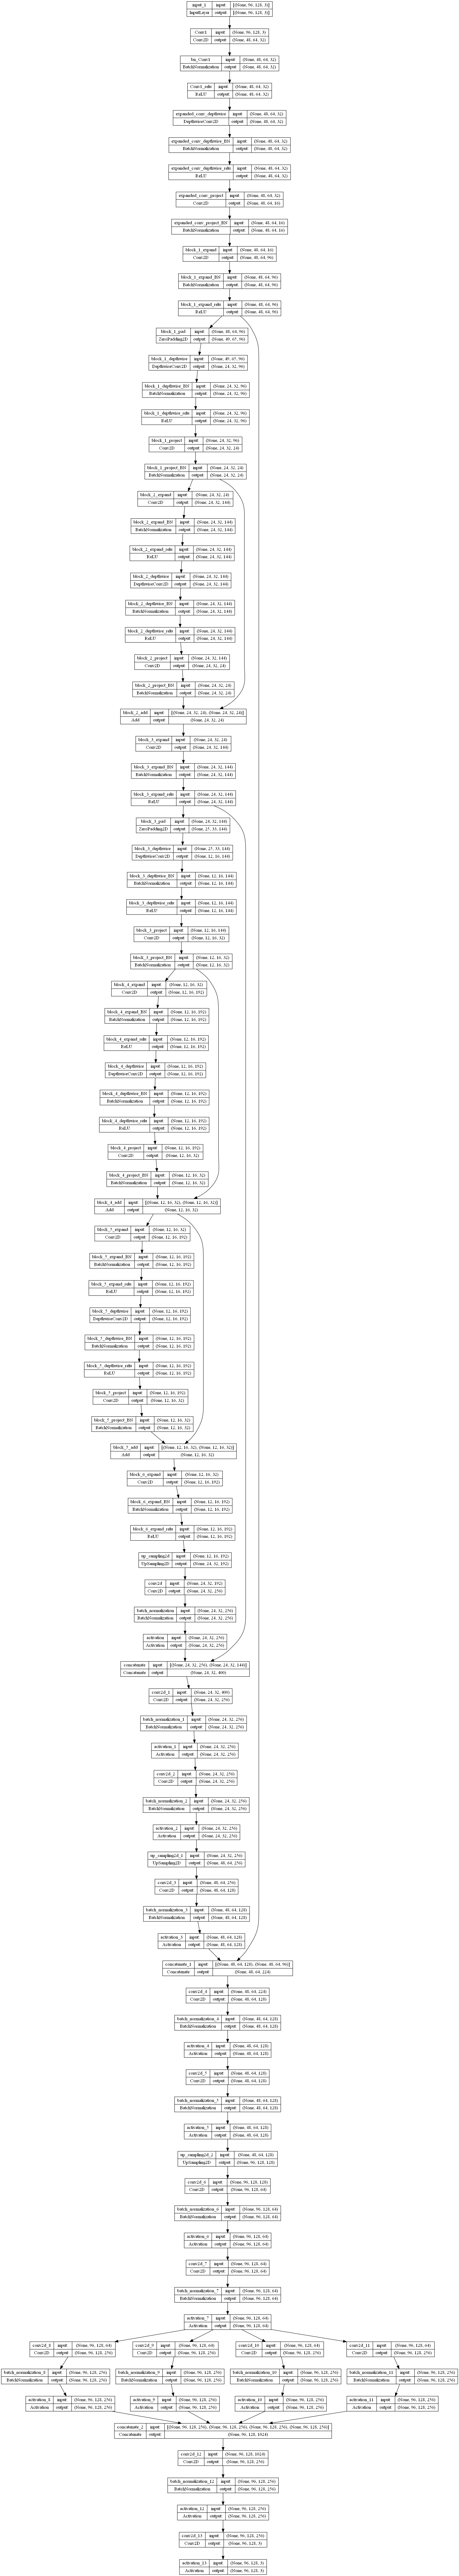

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate, Input
from tensorflow.keras.applications import MobileNetV2

def conv_block(x, filters):
    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# def encoder_decoder(inputs):
#     # MobileNetV2 encoder
#     base_model = MobileNetV2(include_top=False, weights=None, input_tensor=inputs)

#     # Get the feature map at the fourth block
#     encoder_output = base_model.get_layer("block_6_expand_relu").output

#     # Start the decoder part
#     x = UpSampling2D((4, 4))(encoder_output)
#     x = Concatenate()([x, base_model.get_layer("block_3_expand_relu").output])
#     x = conv_block(x, 256)

#     x = UpSampling2D((2, 2))(x)
#     x = Concatenate()([x, base_model.get_layer("block_1_expand_relu").output])
#     x = conv_block(x, 128)

#     x = UpSampling2D((2, 2))(x)
#     x = conv_block(x, 64)

#     return x

def encoder_decoder(inputs):
    # MobileNetV2 encoder
    base_model = MobileNetV2(include_top=False, weights=None, input_tensor=inputs)

    # Get the feature map at the fourth block
    encoder_output = base_model.get_layer("block_6_expand_relu").output

    # Start the decoder part
    x = UpSampling2D((2, 2))(encoder_output)
    x = Conv2D(256, (1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Concatenate()([x, base_model.get_layer("block_3_expand_relu").output])
    x = conv_block(x, 256)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (1, 1), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Concatenate()([x, base_model.get_layer("block_1_expand_relu").output])
    x = conv_block(x, 128)

    x = UpSampling2D((2, 2))(x)
    x = conv_block(x, 64)

    return x


def aspp(x, filters):
    shape = x.shape

    y1 = Conv2D(filters, (1, 1), padding="same")(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(filters, (3, 3), padding="same", dilation_rate=(6, 6))(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filters, (3, 3), padding="same", dilation_rate=(12, 12))(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filters, (3, 3), padding="same", dilation_rate=(18, 18))(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y = Concatenate()([y1, y2, y3, y4])

    y = Conv2D(filters, (1, 1), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def deeplabv3_plus_model():
    inputs = Input((image_height, image_width, num_channels))

    x = encoder_decoder(inputs)
    x = aspp(x, 256)

    x = Conv2D(num_classes, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)

    model = Model(inputs, x)

    return model

# Specify the dimensions by using the image
image_height = train_images[0].shape[0]
image_width = train_images[0].shape[1]
num_classes = 3
num_channels = 3

# Create an instance of the DeepLabV3 model
DLV3plus_model_created = deeplabv3_plus_model()

# Print the model summary
DLV3plus_model_created.summary()

keras.utils.plot_model(DLV3plus_model_created, show_shapes=True)


In [54]:
# Step 5: Train the model
# Compile the model
# DLV3plus_model_created.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define the callbacks
# callbacks = [
#     ModelCheckpoint("unet_model_seg.h5", verbose=1, save_best_only=True),
#     EarlyStopping(patience=5, monitor='val_loss')
# ]

def train_modelz(model_instance_name, epochs, batch_size):

    # Compile the model
    model_instance_name.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    # history = unet_model_created.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10, batch_size=16, callbacks=callbacks)
    history = model_instance_name.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=epochs, batch_size=batch_size)

    # Step 6: Evaluate the model

    # Evaluate the model on the test set
    test_loss, test_acc = model_instance_name.evaluate(test_images, test_masks, verbose=2)

    # Print the accuracy on the test set
    print('\nTest accuracy:', test_acc)

    return model_instance_name, history


In [48]:
# # model, history = train_model("model_instance_name", epochs, batch_size):
# model1, history = train_model("model_instance_name", 1, 16)


In [ ]:
# # model, history = train_model("model_instance_name", epochs, batch_size):
# model1, history = train_model("model_instance_name", 1, 16)

# plot_loss_and_accuracy(history)
# plot_confusion_matrix(train_images, train_masks, model1)

# # Plot the image and predicted mask for a sample image
# sample_image_index = 0
# plot_image_with_mask(train_images[sample_image_index], train_masks[sample_image_index], model1)

# show_predictions(model1)

# plot_image_with_mask(history)



In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... Existing code ...

# Step 4: Train a U-Net model
# ...

# Step 5: Train the model
# ...

# Plot training and validation loss and accuracy
def plot_loss_and_accuracy(history):
    plt.figure(figsize=[12, 4])

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### plot_loss_and_accuracy(history)

# Step 6: Evaluate the model
# ...

# Plot confusion matrices
def plot_confusion_matrix(images, masks, model):
    # Predict masks for the images
    predicted_masks = model.predict(images)

    # Convert masks and predicted masks to categorical
    masks_categorical = np.argmax(masks, axis=3)
    predicted_masks_categorical = np.argmax(predicted_masks, axis=3)

    # Calculate confusion matrices
    train_confusion_mtx = confusion_matrix(np.ravel(masks_categorical), np.ravel(predicted_masks_categorical))

    # Plot confusion matrices
    plt.figure(figsize=[12, 6])

    plt.subplot(1, 2, 1)
    sns.heatmap(train_confusion_mtx, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Training Confusion Matrix')

    plt.tight_layout()
    plt.show()

### plot_confusion_matrix(train_images, train_masks, DLV3plus_model_created)

# Plot the original image and predicted mask
def plot_image_with_mask(image, mask, model):
    # Predict the mask for the image
    predicted_mask = model.predict(np.expand_dims(image, axis=0))

    # Convert mask and predicted mask to categorical
    mask_categorical = np.argmax(mask, axis=2)
    predicted_mask_categorical = np.argmax(predicted_mask[0], axis=2)

    # Plot the image and predicted mask
    plt.figure(figsize=[12, 6])

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask_categorical)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# # Plot the image and predicted mask for a sample image
# sample_image_index = 0
# plot_image_with_mask(train_images[sample_image_index], train_masks[sample_image_index], DLV3plus_model_created)

# Step 7: Save and load the model
# ...

import random
train_testing_id = random.randint(0, len(train_images))

def display(display_list):
    plt.figure(figsize=(20, 20))

    try:
    
        title = ['Input Image', 'True Mask', 'Predicted Mask',]

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    except:
    
        title = ['Input Image 1', 'True Mask 1', 'Predicted Mask 1', 'Input Image 2', 'True Mask 2', 'Predicted Mask 2']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

def show_predictions(model, x_train = train_images, y_train = train_masks, num=1):
    #try:
    pred_mask = model.predict(np.expand_dims(x_train[train_testing_id], 0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    display([train_images[train_testing_id], train_masks[train_testing_id], pred_mask])

# show_predictions(DLV3plus_model_created)

def plot_image_with_mask(history):

    # Plot the training and validation accuracy and loss at each epoch
    history_df = pd.DataFrame(history.history)
    history_df[['loss', 'val_loss']].plot()
    history_df[['accuracy', 'val_accuracy']].plot()

    # Plot the training and validation loss at each epoch
    history_df = pd.DataFrame(history.history)
    history_df[['loss', 'val_loss']].plot()

    # Plot the training and validation accuracy at each epoch
    history_df = pd.DataFrame(history.history)
    history_df[['accuracy', 'val_accuracy']].plot()


In [51]:

# # Plot the training and validation accuracy and loss at each epoch
# history_df = pd.DataFrame(history.history)
# history_df[['loss', 'val_loss']].plot()
# history_df[['accuracy', 'val_accuracy']].plot()

# # Plot the training and validation loss at each epoch
# history_df = pd.DataFrame(history.history)
# history_df[['loss', 'val_loss']].plot()

# # Plot the training and validation accuracy at each epoch
# history_df = pd.DataFrame(history.history)
# history_df[['accuracy', 'val_accuracy']].plot()

In [40]:
def train_and_eval(model, train, train_y, test, test_y, batch_size, epochs):

    # compile the network
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    # fit the model
    # make the batch size smaller
    # increase the epochs number of iterations of the dataset
    # add decay rate for epoch
    history = model.fit(train, train_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(test, test_y),
                        verbose=False)
    
        # batch_size=16
        # epochs=1

    # Evaluate the model on the test set
    #test_loss, test_acc = model.evaluate(test_images, test_masks, verbose=2)

    # Print the accuracy on the test set
    #print('\nTest accuracy:', test_acc)

    # plot training and validation loss and accuracy
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend()

    # plot confusion matrices and F1 scores
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    pred = model.predict(train, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    ax = fig.add_subplot(1, 2, 2)    
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))
     

In [23]:
import time
from time import process_time

In [52]:
# # batch size = 16
# # epochs = 1
# without_aug_start = process_time()
# train_and_eval(DLV3plus_model_created, train_images, train_masks, test_images, test_masks, 16, 1)
# without_aug_stop = process_time()
# print('Time to train and evaluate without augmentation: %f' % (without_aug_stop - without_aug_start))

# ACTUAL EVALUATIONS    

1 Epoch  
16 Batch Size  

18/18 [==============================] - 136s 7s/step - loss: 603.9941 - accuracy: 0.5544 - val_loss: 1110.4427 - val_accuracy: 0.3808
2/2 - 7s - loss: 1081.1970 - accuracy: 0.3986 - 7s/epoch - 4s/step

Test accuracy: 0.39860230684280396


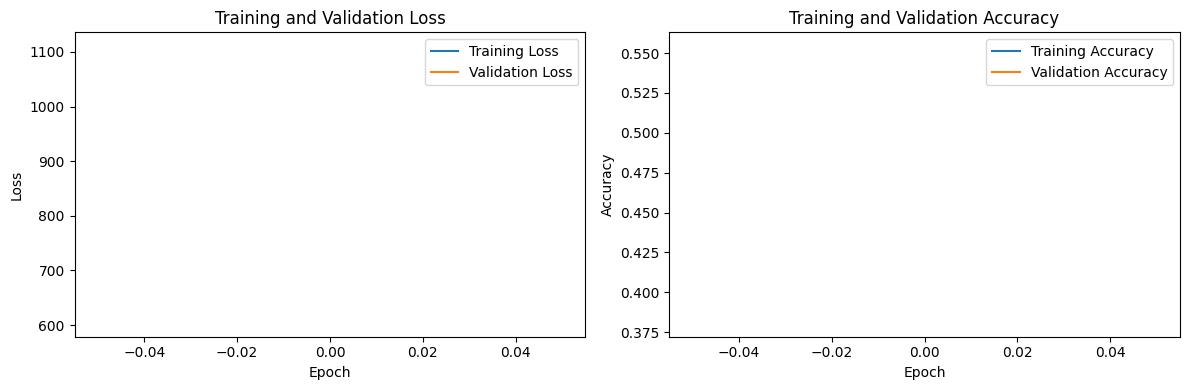

9/9 [==============================] - 50s 5s/step


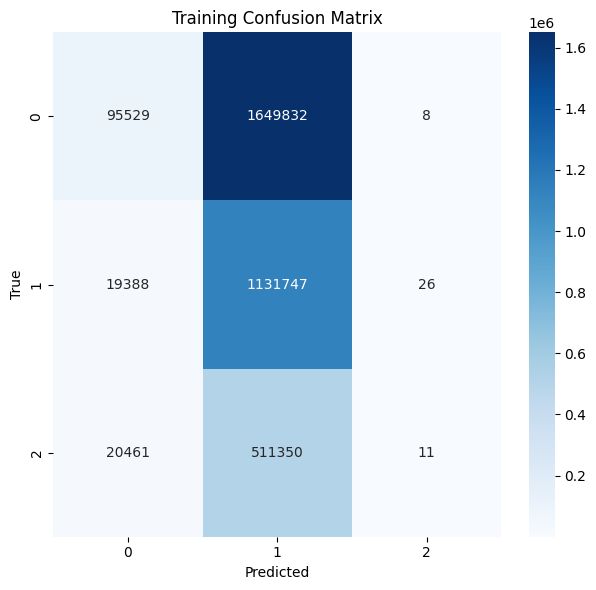

1/1 [==============================] - 0s 220ms/step


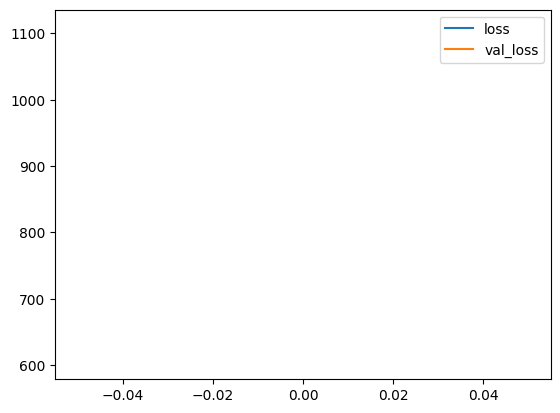

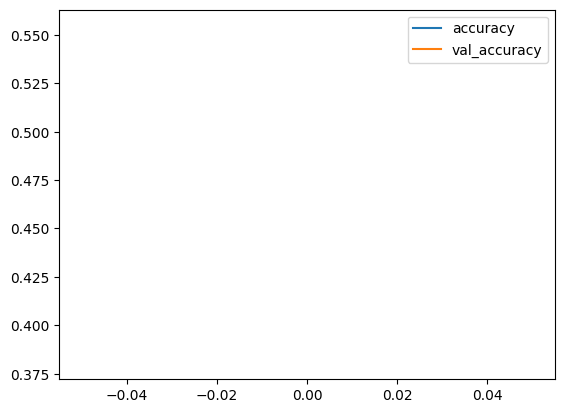

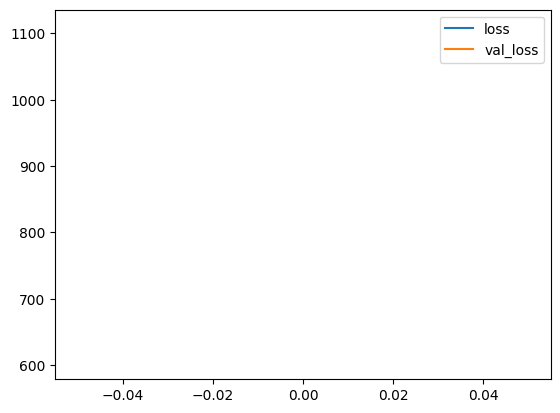

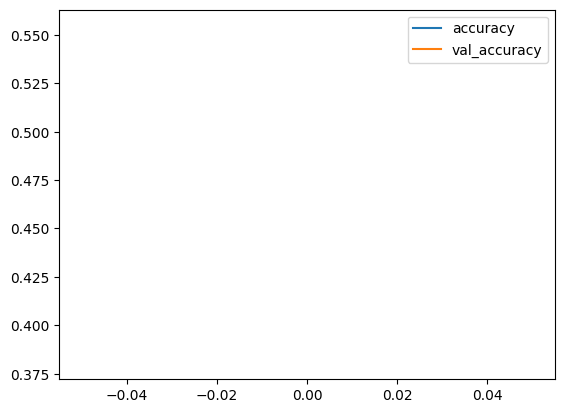

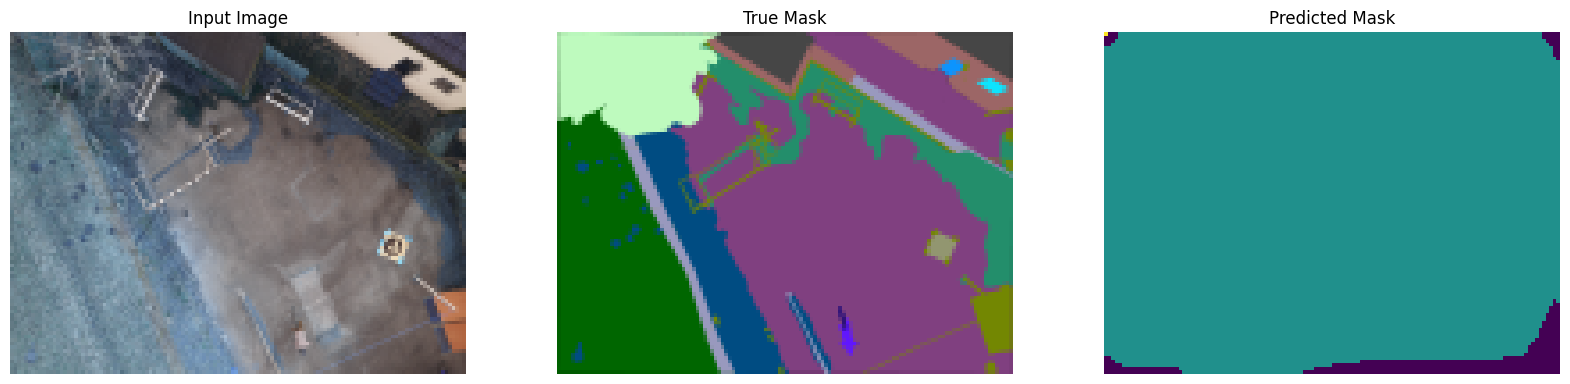

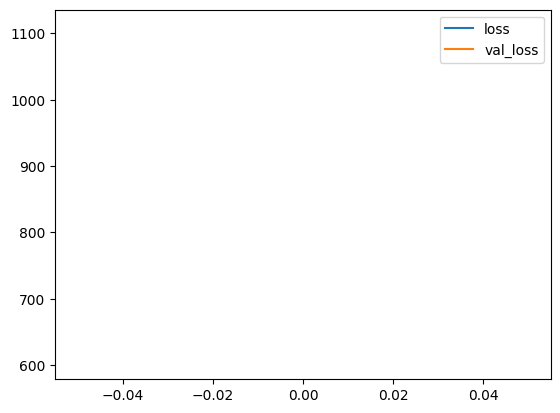

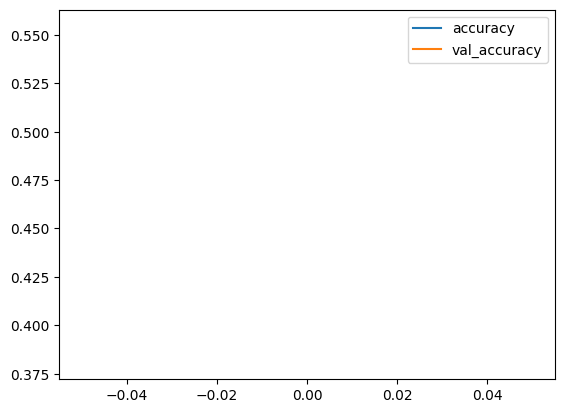

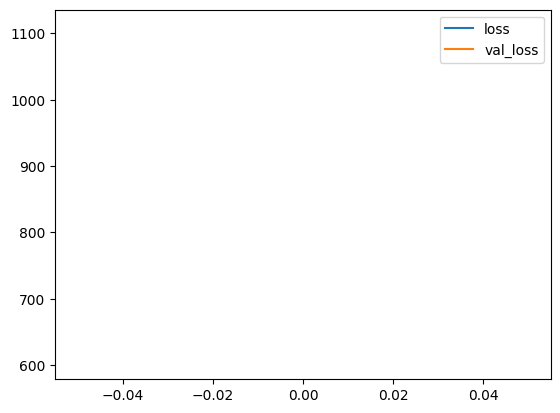

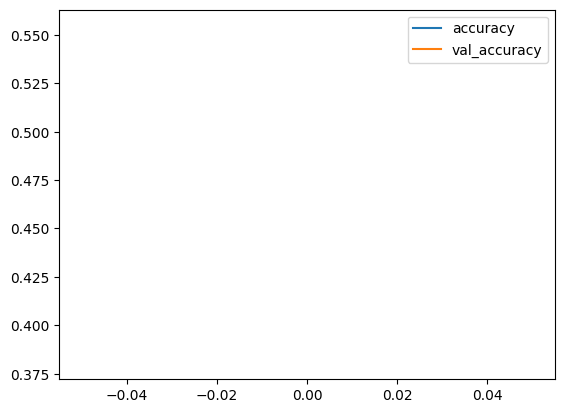

In [56]:
# model, history = train_model("model_instance_name", epochs, batch_size):
model1, history1 = train_modelz("model_instance_name", 1, 16)

# plot the loss and accuracy
plot_loss_and_accuracy(history1)

# Plot the confusion matrix on the training data
plot_confusion_matrix(train_images, train_masks, model1)

# Plot the image and predicted mask for a sample image
# sample_image_index = 0
# plot_image_with_mask(train_images[sample_image_index], train_masks[sample_image_index], model1)
plot_image_with_mask(history1)

# show_predictions(model1)
show_predictions(model1)

# Plot the confusion matrix on the test data
plot_image_with_mask(history1)